In [2]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms, models
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
import torch.nn as nn
import time

## Loading Data

In [3]:
with open("test_image.pkl", "rb") as f:
    testImages = pickle.load(f)

with open("train_image.pkl", "rb") as f:
    trainImages = pickle.load(f)
with open("train_label.pkl", "rb") as f:
    trainLabels = pickle.load(f)

In [4]:
# Replacing class label 6 with 1
for i in range(8000):
    if(trainLabels[i]==6): 
        trainLabels[i] = 1

In [5]:
trainImages = np.asarray(trainImages)
trainImages = trainImages.reshape(-1,1,28,28)
testImages = np.asarray(testImages)
testImages = testImages.reshape(-1,1,28,28)

trainImages = (torch.from_numpy(trainImages)).float()
trainLabels = torch.from_numpy(np.asarray(trainLabels))
testImages = (torch.from_numpy(np.asarray(testImages))).float()

In [6]:
# plt.imshow(trainImages[0].reshape((28,28)))
# print(trainLabels[0])

In [7]:
BatchSize = 100

trainset = torch.utils.data.TensorDataset(trainImages, trainLabels)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4)

In [8]:
print('No. of samples in train set: '+str(len(trainLoader.dataset)))

No. of samples in train set: 8000


## Defining network architecture
#### CNN LeNet 

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)


In [10]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [11]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available !')   
    net = net.cuda()
else:
    print('GPU unavailable !')

GPU unavailable !


In [12]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-5) # Adam

## training model

/home/harshit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 /100  ;  Training Loss: 0.012481 ; Time consumed: 0m 1s 
Iteration: 2 /100  ;  Training Loss: 0.010075 ; Time consumed: 0m 1s 
Iteration: 3 /100  ;  Training Loss: 0.009009 ; Time consumed: 0m 1s 
Iteration: 4 /100  ;  Training Loss: 0.008415 ; Time consumed: 0m 1s 
Iteration: 5 /100  ;  Training Loss: 0.008045 ; Time consumed: 0m 1s 
Iteration: 6 /100  ;  Training Loss: 0.007750 ; Time consumed: 0m 1s 
Iteration: 7 /100  ;  Training Loss: 0.007523 ; Time consumed: 0m 1s 
Iteration: 8 /100  ;  Training Loss: 0.007336 ; Time consumed: 0m 1s 
Iteration: 9 /100  ;  Training Loss: 0.007176 ; Time consumed: 0m 1s 
Iteration: 10 /100  ;  Training Loss: 0.007023 ; Time consumed: 0m 1s 
Iteration: 11 /100  ;  Training Loss: 0.006900 ; Time consumed: 0m 1s 
Iteration: 12 /100  ;  Training Loss: 0.006778 ; Time consumed: 0m 1s 
Iteration: 13 /100  ;  Training Loss: 0.006676 ; Time consumed: 0m 1s 
Iteration: 14 /100  ;  Training Loss: 0.006584 ; Time consumed: 0m 1s 
Iteration: 15 /

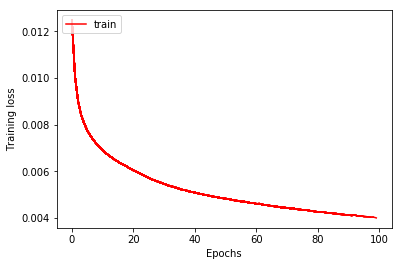

In [13]:
iterations = 100
trainLoss = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = net(inputs)        
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data 
    avgTrainLoss = runningLoss/8000.0
    trainLoss.append(avgTrainLoss)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')       
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

## Predicting test labels and saving into file

In [14]:
if use_gpu:
    inputs = Variable(testImages.cuda())  
else:
    inputs = Variable(testImages)

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)
finalPred = predicted.cpu().numpy()

# Replacing class label 1 with 6
for i in range(2000):
    if finalPred[i] == 1:
        finalPred[i] = 6

/home/harshit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
# Saving predictions into a file
x = np.arange(0, 2000, 1)
x.astype(int)
final = np.asarray((x,finalPred),dtype = int)
np.savetxt("Testlabel.csv",final.T,fmt='%d' ,delimiter=',', header='image,pred',comments='')